# **Regularized Logistic Regression**

In this notebook, we will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. 

# **Problem Statement**

Suppose I am the product manager of the factory and we have the test results for some microchips on two different tests. 
- From these two tests, we would like to determine whether the microchips should be accepted or rejected. 
- To help us make the decision, we have a dataset of test results on past microchips, from which we can build a logistic regression model.

# **Loading and visualizing the data**

Let's start by loading the dataset for this task and visualizing it. 

- The `load_dataset()` function shown below loads the data into variables `X_train` and `y_train`
  - `X_train` contains the test results for the microchips from two tests
  - `y_train` contains the results of the QA  
      - `y_train = 1` if the microchip was accepted 
      - `y_train = 0` if the microchip was rejected 
  - Both `X_train` and `y_train` are numpy arrays.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
from google.colab import drive
import matplotlib.image as mpimg 
drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y


In [52]:
# load dataset
path_testing = "/content/drive/MyDrive/Code/logistic-regression-models/ex2data2.txt"
X_train, y_train = load_data(path_testing)

# **View the variables**

The code below prints the first five values of `X_train` and `y_train` and the type of the variables.


In [53]:
# print X_train
print("X_train:", X_train[:5])
print("Type of X_train:",type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Type of y_train:",type(y_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Type of X_train: <class 'numpy.ndarray'>
y_train: [1. 1. 1. 1. 1.]
Type of y_train: <class 'numpy.ndarray'>


#### **Check the dimensions of variables**

Another useful way to get familiar with the data is to view its dimensions. Let's print the shape of `X_train` and `y_train` and see how many training examples we have in our dataset.

In [54]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (118, 2)
The shape of y_train is: (118,)
We have m = 118 training examples


#### **Visualize the data**



In [55]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)

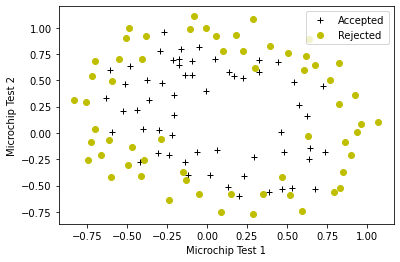

In [56]:
# Plot examples
plot_data(X_train, y_train[:], pos_label="Accepted", neg_label="Rejected")

# Set the y-axis label
plt.ylabel('Microchip Test 2') 
# Set the x-axis label
plt.xlabel('Microchip Test 1') 
plt.legend(loc="upper right")
plt.show()

Figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.


# **Feature mapping**

One way to fit the data better is to create more features from each data point. In the provided function `map_feature`, we will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power.

$$\mathrm{map\_feature}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 27-dimensional vector. 

- A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will be nonlinear when drawn in our 2-dimensional plot.  

In [57]:
def map_feature(X1, X2):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)


In [58]:
print("Original shape of data:", X_train.shape)

mapped_X =  map_feature(X_train[:, 0], X_train[:, 1])
print("Shape after feature mapping:", mapped_X.shape)

Original shape of data: (118, 2)
Shape after feature mapping: (118, 27)


Let's also print the first elements of `X_train` and `mapped_X` to see the tranformation.

In [59]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [5.12670000e-02 6.99560000e-01 2.62830529e-03 3.58643425e-02
 4.89384194e-01 1.34745327e-04 1.83865725e-03 2.50892595e-02
 3.42353606e-01 6.90798869e-06 9.42624411e-05 1.28625106e-03
 1.75514423e-02 2.39496889e-01 3.54151856e-07 4.83255257e-06
 6.59422333e-05 8.99809795e-04 1.22782870e-02 1.67542444e-01
 1.81563032e-08 2.47750473e-07 3.38066048e-06 4.61305487e-05
 6.29470940e-04 8.58939846e-03 1.17205992e-01]


# **Cost function for regularized logistic regression**

In this part, we will implement the cost function for regularized logistic regression.

Recall that for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Compare this to the cost function without regularization, which is of the form 

$$ J(\mathbf{w}.b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right]$$

The difference is the regularization term, which is $$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$ 
Note that the $b$ parameter is not regularized.

In [60]:
def sigmoid(z):

    g = 1/(1+np.exp(-z))
    
    return g

In [61]:
def compute_cost(X, y, w, b, lambda_= 1):

    m, n = X.shape
    
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
    total_cost = cost/m 

    return total_cost

Please complete the `compute_cost_reg` function below to calculate the following term for each element in $w$ 
$$\frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

The starter code then adds this to the cost without regularization (which you computed above in `compute_cost`) to calculate the cost with regulatization.

In [62]:

def compute_cost_reg(X, y, w, b, lambda_ = 1):

    m, n = X.shape
    
    # Calls the compute_cost function that you implemented above
    cost_without_reg = compute_cost(X, y, w, b) 
    
    # We need to calculate this value
    reg_cost = 0.
    
    for j in range(n):
        reg_cost += (w[j]**2)
    
    
    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost

    return total_cost

**Run the cell below to check the implementation of the compute_cost_reg function.**

In [63]:
X_mapped = map_feature(X_train[:, 0], X_train[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost_reg(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)

Regularized cost : 0.6618252552483948



# **Gradient for regularized logistic regression**

In this section, we will implement the gradient for regularized logistic regression.


The gradient of the regularized cost function has two components. The first, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ is a scalar, the other is a vector with the same shape as the parameters $\mathbf{w}$, where the $j^\mathrm{th}$ element is defined as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})  $$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$

Compare this to the gradient of the cost function without regularization (which you implemented above), which is of the form 
$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$


As we can see,$\frac{\partial J(\mathbf{w},b)}{\partial b}$ is the same, the difference is the following term in $\frac{\partial J(\mathbf{w},b)}{\partial w}$, which is $$\frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$ 





We have to complete the `compute_gradient_reg` function below to modify the code below to calculate the following term

$$\frac{\lambda}{m} w_j  \quad\, \mbox{for $j=0...(n-1)$}$$

The starter code will add this term to the $\frac{\partial J(\mathbf{w},b)}{\partial w}$ returned from `compute_gradient` above to get the gradient for the regularized cost function.



In [64]:
def compute_gradient(X, y, w, b, lambda_=None): 

    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)
        err_i = f_wb_i - y[i]
        for j in range(n): 
            dj_dw[j] += err_i*X[i,j]
        
        dj_db += err_i
        
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    
    return dj_db, dj_dw

In [65]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1): 
    m, n = X.shape
    
    dj_db, dj_dw = compute_gradient(X, y, w, b)
     
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]         
        
    return dj_db, dj_dw


### **Learning parameters using gradient descent**
We will use our gradient descent function implemented above to learn the optimal parameters $w$,$b$. 

In [66]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [67]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ to 1 (we can try varying this)
lambda_ = 0.01;                                          
# Some gradient descent settings
iterations = 10000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_mapped, y_train, initial_w, initial_b, 
                                    compute_cost_reg, compute_gradient_reg, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.72   
Iteration 1000: Cost     0.59   
Iteration 2000: Cost     0.56   
Iteration 3000: Cost     0.53   
Iteration 4000: Cost     0.51   
Iteration 5000: Cost     0.50   
Iteration 6000: Cost     0.48   
Iteration 7000: Cost     0.47   
Iteration 8000: Cost     0.46   
Iteration 9000: Cost     0.45   
Iteration 9999: Cost     0.45   


### **Evaluating regularized logistic regression model**

We will use the `predict` function that we implemented above to calculate the accuracy of the regulaized logistic regression model on the training set

In [68]:
def predict(X, w, b): 
    
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    
    # Loop over each example
    for i in range(m):   
        z_wb = 0
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb_ij = X[i, j] * w[j]
            z_wb += z_wb_ij
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        if f_wb >= 0.5:
            p[i] = 1
        else:
            p[i] = 0
        
    return p

In [69]:
#Compute accuracy on the training set
p = predict(X_mapped, w, b)

print('Train Accuracy: %f'%(np.mean(p == y_train) * 100))

Train Accuracy: 82.203390
